In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
disaster_df = pd.read_csv("../data/data.csv") #load the dataset

In [3]:
disaster_df.head() #view the first 5 data entries

,Unnamed: 0,Id,class,num_sibling/spouse,num_parent/child,ticket,price,Seat,departure_from,gender,alive,age
0,0,1,3,1,0,CUGSP1ULC1,7.2500,NaN,S,male,0,22.0
1,1,2,1,1,0,RWKPI7Y5RI,71.2833,C85,C,female,1,38.0
2,2,3,3,0,0,DTHA121ED6,7.9250,NaN,S,female,1,26.0
3,3,4,1,1,0,B46YX3C4TM,53.1000,C123,S,female,1,35.0
4,4,5,3,0,0,YJKMT1KA7C,8.0500,NaN,S,male,0,35.0


In [4]:
disaster_df.isnull().sum() #see which variable contains missing data

Unnamed: 0              0
Id                      0
class                   0
num_sibling/spouse      0
num_parent/child        0
ticket                  0
price                   0
Seat                  668
departure_from          2
gender                  0
alive                   0
age                   174
dtype: int64

<AxesSubplot:ylabel='Density'>

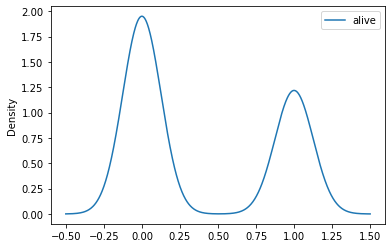

In [5]:
#seat is obviously dropped due to large number and departire_from can drop the data entry due to small number
disaster_df.plot(x = "age", y = "alive", kind="density") #check if age can be dropped

In [6]:
disaster_df = disaster_df.dropna(subset = ["departure_from"]) #remove blank entry of departure_from
disaster_df = disaster_df.drop(["Unnamed: 0", "Id", "Seat", "ticket"], axis = 1) #drop unnecessary predictor
disaster_df["age"] = disaster_df["age"].fillna(disaster_df["age"].mean()) #fill age with mean of existing data since age canno tbe dropped as shown in the graph

In [7]:
corr_table = disaster_df.corr().abs().style.background_gradient() #make correlation table to drop potential harmful predictor

<ipython-input-7-c1b476271be9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_table = disaster_df.corr().abs().style.background_gradient() #make correlation table to drop potential harmful predictor


In [8]:
corr_table

,class,num_sibling/spouse,num_parent/child,price,alive,age
class,1.000000,0.083923,0.013164,0.550570,0.331218,0.328359
num_sibling/spouse,0.083923,1.000000,0.424664,0.159181,0.039721,0.234771
num_parent/child,0.013164,0.424664,1.000000,0.219934,0.086437,0.192061
price,0.550570,0.159181,0.219934,1.000000,0.254530,0.084406
alive,0.331218,0.039721,0.086437,0.254530,1.000000,0.074360
age,0.328359,0.234771,0.192061,0.084406,0.074360,1.000000


In [9]:
#get dummy variables for categorical variables
disaster_df = pd.get_dummies(disaster_df, columns = ["class", "departure_from", "gender"])

In [10]:
X = disaster_df.drop(["alive"], axis = 1)
y = disaster_df["alive"]

In [11]:
X.head() #check if X is correct

,num_sibling/spouse,num_parent/child,price,age,class_1,class_2,class_3,departure_from_C,departure_from_Q,departure_from_S,gender_female,gender_male
0,1,0,7.2500,22.0,0,0,1,0,0,1,0,1
1,1,0,71.2833,38.0,1,0,0,1,0,0,1,0
2,0,0,7.9250,26.0,0,0,1,0,0,1,1,0
3,1,0,53.1000,35.0,1,0,0,0,0,1,1,0
4,0,0,8.0500,35.0,0,0,1,0,0,1,0,1


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=2) #split to training and testing sets

In [13]:
#svm model
from sklearn import svm
clf = svm.SVC(kernel = "linear", C = 1, class_weight = {0: 0.55, 1: 0.45})
clf.fit(X_train, y_train)

SVC(C=1, class_weight={0: 0.55, 1: 0.45}, kernel='linear')

In [14]:
clf.score(X_test, y_test) #get accuracy

0.861271676300578

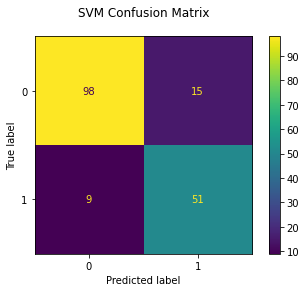

In [15]:
#confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm2 = confusion_matrix(clf.predict(X_test), y_test)
ConfusionMatrixDisplay(cm2, display_labels = clf.classes_).plot()
plt.title("SVM Confusion Matrix", pad=20)
plt.show()

In [16]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(np.array(y_test), clf.predict(X_test), digits=4))

              precision    recall  f1-score   support

           0     0.8673    0.9159    0.8909       107
           1     0.8500    0.7727    0.8095        66

    accuracy                         0.8613       173
   macro avg     0.8586    0.8443    0.8502       173
weighted avg     0.8607    0.8613    0.8599       173



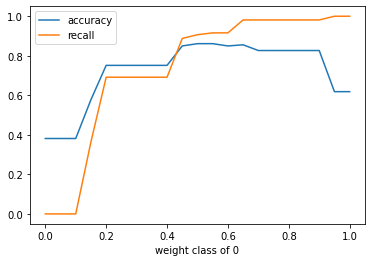

In [24]:
# find the trade off of different class weight in terms of accuracy and reccall score to minimize false negatives
# note that fitting 100 svm model may take quite a while
weight_0 = []
acc_score = []
fnr = []
for i in np.arange(0,1.01,0.05):
    weight_0.append(i)
    clf2 = svm.SVC(kernel = "linear", C = 1, class_weight = {0: i, 1: 1-i})
    clf2.fit(X_train, y_train)
    acc_score.append(clf2.score(X_test, y_test))
    cmclf = confusion_matrix(clf2.predict(X_test), y_test)
    fnr.append(cmclf[0][0]/(cmclf[0][0]+cmclf[1][0]))
plt.plot(weight_0, acc_score, label = "accuracy")
plt.plot(weight_0, fnr, label = "recall")
plt.xlabel("weight class of 0")
plt.legend()
plt.show()

In [18]:
#logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight = {0: 0.6, 1: 0.4}, max_iter = 500).fit(X_train, y_train)

In [19]:
model.score(X_test, y_test) #get accuracy

0.8497109826589595

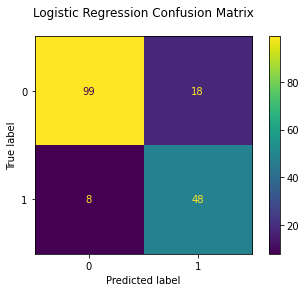

In [20]:
#confusion matrix
cm = confusion_matrix(model.predict(X_test), y_test)
ConfusionMatrixDisplay(cm, display_labels = model.classes_).plot()
plt.title("Logistic Regression Confusion Matrix", pad=20)
plt.show()

In [21]:
#classification report
print(classification_report(np.array(y_test), model.predict(X_test), digits=4))

              precision    recall  f1-score   support

           0     0.8462    0.9252    0.8839       107
           1     0.8571    0.7273    0.7869        66

    accuracy                         0.8497       173
   macro avg     0.8516    0.8263    0.8354       173
weighted avg     0.8503    0.8497    0.8469       173



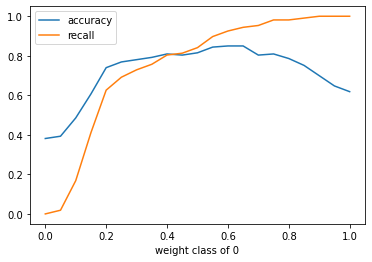

In [25]:
# find the trade off of different class weight in terms of accuracy and reccall score to minimize false negatives
weight_0_m = []
acc_score_m = []
fnr_m = []
for i in np.arange(0,1.01,0.05):
    weight_0_m.append(i)
    model2 = LogisticRegression(class_weight = {0: i, 1: 1-i}, max_iter=500)
    model2.fit(X_train, y_train)
    acc_score_m.append(model2.score(X_test, y_test))
    cmmod = confusion_matrix(model2.predict(X_test), y_test)
    fnr_m.append(cmmod[0][0]/(cmmod[0][0]+cmmod[1][0]))
plt.plot(weight_0_m, acc_score_m, label = "accuracy")
plt.plot(weight_0_m, fnr_m, label = "recall")
plt.xlabel("weight class of 0")
plt.legend()
plt.show()

In [23]:
# uncomment to save the models
# pickle.dump(model, open("log_final.sav", "wb"))
# pickle.dump(clf, open("svm_final.sav", "wb"))